# Improved localization in MWA Tied array beam observations 
Following the method implemented by [Bezuidenhout et al. 2023](https://ui.adsabs.harvard.edu/abs/2023RASTI...2..114B/abstract) in [SeeKAT](https://github.com/BezuidenhoutMC/SeeKAT).

[Meyers et al. in prep.]()

## Prerequisites

In [1]:
# For basic algebra and stats
import numpy as np
import scipy.stats as st

# Astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

# For visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
import cmasher as cms

# Setting latex fonts in Matplotlib
rc('text', usetex=True)
rc('font', family='serif')

# Version check and print
from print_versions import print_versions
print_versions(globals())

numpy==1.23.1
astropy==5.1
matplotlib==3.5.2
cmasher==1.6.3


## Data 

### Part I - tied array beams

This is the data behind $T(\hat{q})$ which is defined in eq. 6 in the paper.

Command behind the data used here:

```bash
export MWA_BEAM_FILE=../data/mwa_full_embedded_element_pattern.h5

wa_tab_loc -m ../data/1253471952.metafits -f 155000000 -t "2019-11-19T17:59:50" -L "04:52:41.10_-34:21:11.10 04:51:47.06_-34:21:11.10 04:52:14.13_-34:11:21.12 04:52:14.02_-34:31:01.07 04:51:20.20_-34:11:21.12 04:51:19.99_-34:31:01.07" --gridbox "04:46:00 -33:30:00 04:58:00 -35:10:00 5 5" --plot
```

Data are just numpy arrays, saved in `npy` and `npz` formats for quick load.

**Note**: We are only dealing with single-frequency data for the moment.


In [2]:
def data_reader(tabp_file, grid_file):
    tabp_look = np.load(tabp_file)
    print("Selecing the first frequency and ignoring all other frequencies")
    tabp_look = tabp_look[:,0,:,:]
    grid_ra = np.load(grid_file)['arr_0']
    grid_dec = np.load(grid_file)['arr_1']
    #product = np.sum(tabp_look.mean(axis=1), axis=0)
    print('tabp dimensions:', tabp_look.shape)
    #print('product dimensions:', product.shape)
    print('RA/Dec grid dimensions:', grid_ra.shape, grid_dec.shape)
    
    return tabp_look, grid_ra, grid_dec


TABP_LOOK, GRID_RA, GRID_DEC = data_reader('./tabp_look.npy', './grid.npz')

Selecing the first frequency and ignoring all other frequencies
tabp dimensions: (6, 1225, 1766)
RA/Dec grid dimensions: (1225, 1766) (1225, 1766)


### Part II - Measured Signal-to-Noise ratios per each beam

In [3]:
OBS_SNR_TABLE = Table.read('obs_snr.dat', format='csv')
OBS_SNR = OBS_SNR_TABLE['snr'].value
OBS_BEAM_CENTERS = SkyCoord(OBS_SNR_TABLE['ra'],OBS_SNR_TABLE['dec'],frame='icrs',unit=(u.hourangle, u.deg))

OBS_SNR_TABLE

ra,dec,snr
str11,str12,float64
04:52:41.10,-34:21:11.10,13.0
04:51:47.06,-34:21:11.10,26.0
04:52:14.13,-34:11:21.12,21.0
04:52:14.02,-34:31:01.07,10.0
04:51:20.20,-34:11:21.12,8.0
04:51:19.99,-34:31:01.07,8.0


### Part III - Visualizing the beams

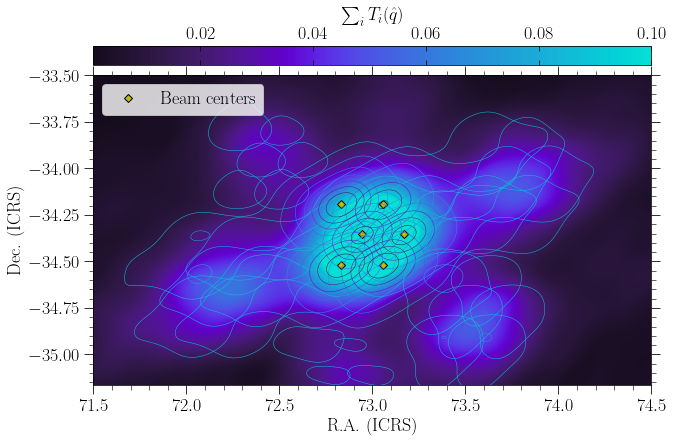

In [4]:
def beam_plot(beam_cen_coords, tabp, grid_ra, grid_dec, label, contours=True):
    tabp_sum = np.sum(tabp, axis=0)

    map_extent = [grid_ra.min(),
                  grid_ra.max(),
                  grid_dec.min(),
                  grid_dec.max()]
    
    aspect = 'equal'    

    cmap = cms.get_sub_cmap(cms.cosmic,0.1,0.9)
    contour_cmap = cms.get_sub_cmap(cms.cosmic_r,0.1,0.9)
    cmapnorm_sum = colors.Normalize(vmin=1e-3, vmax=0.1, clip=True)
    cmapnorm_indiv = colors.Normalize(vmin=1e-3, vmax=0.05, clip=True)
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,1,1)
    ax1_img = ax1.imshow(tabp_sum,
                         aspect=aspect, extent=map_extent, cmap=cmap, norm=cmapnorm_sum)

    ax1.plot(beam_cen_coords.ra.deg,beam_cen_coords.dec.deg,'Dy',mec='k', ms=5, label='Beam centers')

    if contours:
        for ls, look in enumerate(tabp):
            ct = ax1.contour(look, origin='image', extent=map_extent, cmap=contour_cmap, norm=cmapnorm_indiv, linewidths=0.5)
    
    ax1.legend(fontsize=18, loc=2)
    ax1.set_xlabel('R.A. (ICRS)',fontsize=18,ha='center')
    ax1.set_ylabel('Dec. (ICRS)',fontsize=18,ha='center')
    ax1.minorticks_on()
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='major', length=9)
    ax1.tick_params(axis='both', which='minor', length=4.5)
    ax1.tick_params(axis='both', which='both', direction='out', right=True, top=True)

    cbar = fig.colorbar(ax1_img, ax=fig.axes, shrink=1, orientation='horizontal',location='top', aspect=30, pad=0.02)
    cbar.ax.set_title(label,fontsize=18,ha='center')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(direction='in',length=5,bottom=True,top=True)
    cbar.ax.xaxis.set_tick_params(labelsize=18)
    return fig, ct


beam_plot(OBS_BEAM_CENTERS, TABP_LOOK, GRID_RA, GRID_DEC, r'$\sum_i T_i(\hat{q})$');

The background colormap represents the sum over all look directions. The contour lines are vague representation of individual look directions.

## Inference

### Part I - ratio of detection amplitudes (SNRs)

Partially following the notation from [Bezuidenhout et al. 2023](https://ui.adsabs.harvard.edu/abs/2023RASTI...2..114B/abstract) 

We have $Q$ "detections" (or "looks"), with one of them having the highest $S/N$ ratio, which we will label as $i_\rm{SNRmax}$.

for $i$ in $[1,\cdots,Q]$ and $i \neq i_\rm{SNRmax}$:

$$ S_i = \frac{S/N_{i+1}}{S/N_1}$$

Thus we will have $Q-1$ values of $S_i$. In this code we refer to $S_i$ as `OBS_WEIGHTS`:

In [5]:
OBS_MASK = OBS_SNR<OBS_SNR.max()
OBS_WEIGHTS = OBS_SNR[OBS_MASK]/OBS_SNR.max()
OBS_WEIGHTS

array([0.5       , 0.80769231, 0.38461538, 0.30769231, 0.30769231])

### Part II - the covariance matrix

$$ \textrm{cov}(S_i,S_j) = \frac{1}{T-1}\sum_{t=1}^{T} (S_{i,t}-\bar{S}_{i,t}) (S_{j,t}-\bar{S}_{j,t})\quad,\quad i,j \neq i_\rm{SNRmax} $$

Where $T$ is number of simulated points (`N_SIM` in this code).

For the moment we are assuming nominator and denominator are independent and normally distributed. This is a sufficiently good assumption for MeerKAT perhaps, but for MWA as shown above in data visualization, it is not the best assumption. So we should improve on it.

**TODO**: in our notation, we use $T$ for beams. Need to fix that here.

**TODO**: covariance estimation with consideration for MWA beam covariance.

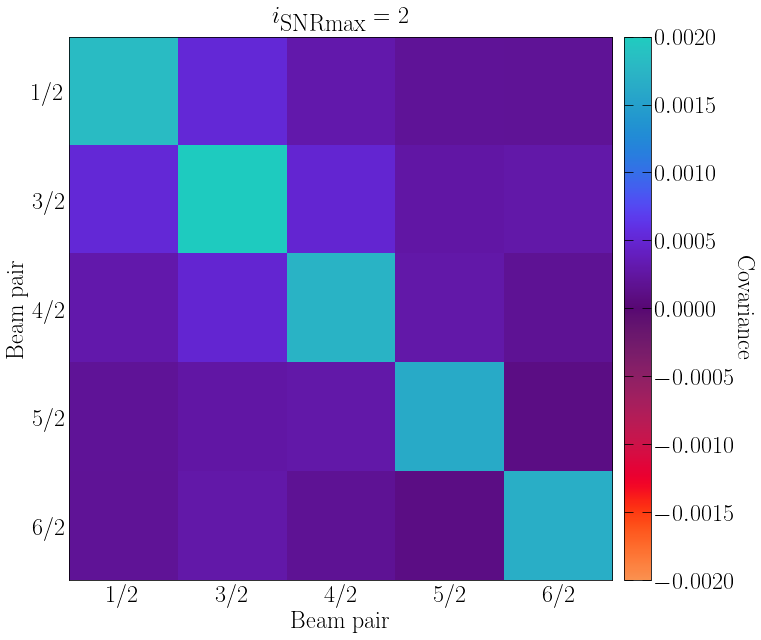

In [6]:
N_SIM = 1000
SIMULATION_SNR = st.multivariate_normal(OBS_SNR).rvs(N_SIM)
SIMULATION_RATIO = SIMULATION_SNR[:,OBS_MASK]/SIMULATION_SNR.T[OBS_SNR.argmax()][:,None]
SIM_COV = np.cov(SIMULATION_RATIO,rowvar=False)

def covariance_plot(covariance, obs_weights, obs_snr, obs_mask):
    fig = plt.figure(figsize=(20,10))
    cmap = cms.get_sub_cmap(cms.guppy,0.0,1.0)
    
    ax1 = fig.add_subplot(1,1,1)
    ax1_img = ax1.imshow(covariance, cmap=cmap, vmin=-0.002,vmax=0.002)
    i_maxsnr = np.argmax(obs_snr)+1
    beam_pair_labels = np.array([f'{obs_i+1}/{i_maxsnr}' for obs_i, obs_snr in enumerate(obs_snr)])[obs_mask]
    ax1.set_xticks(ticks=np.arange(0,len(obs_weights)),labels=beam_pair_labels)
    ax1.set_yticks(ticks=np.arange(0,len(obs_weights)),labels=beam_pair_labels)
    ax1.set_xlabel('Beam pair',fontsize=24,ha='center')
    ax1.set_ylabel('Beam pair',fontsize=24,ha='center')
    ax1.set_title(r'$i_\textrm{SNRmax}=$ '+f'{i_maxsnr}',fontsize=24,va='bottom')
    ax1.tick_params(axis='both', which='major', labelsize=24)
    ax1.tick_params(axis='both', which='major', length=0)
    ax1.tick_params(axis='both', which='both', direction='out', right=True, top=True)
    
    cbar = fig.colorbar(ax1_img, ax=fig.axes, orientation='vertical',location='right', pad=0.01)
    cbar.ax.set_ylabel('Covariance',fontsize=24,rotation=270,labelpad=20)
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.tick_params(which='major',direction='in',length=9,left=True,right=True)
    cbar.ax.yaxis.set_tick_params(labelsize=24)
    return fig


covariance_plot(SIM_COV, OBS_WEIGHTS, OBS_SNR, OBS_MASK);

### Part III - $\chi^2$ and likelihood

$$ \psi_i(\alpha, \delta) = \frac{T_{i}(\alpha, \delta)}{T_{i_\rm{SNRmax}}(\alpha, \delta)} $$

$$ R_i(\alpha, \delta) = S_i - \psi_i(\alpha, \delta) $$

$$ \chi^2(\alpha, \delta) = R^T C^{-1} R $$

In [7]:
def chi2_calc(tabp_look, obs_mask, obs_snr, obs_weights, cov):
    P_array = tabp_look[obs_mask,...]/tabp_look[obs_snr.argmax(),...]
    R_array = obs_weights[:,None,None]-P_array
    cov_inv = np.linalg.inv(cov)
    n_obs = len(obs_snr)
    reshaped_R = np.reshape(R_array, (n_obs-1, -1))
    C_dot_R = np.reshape(np.dot(cov_inv, reshaped_R), R_array.shape)
    chi2 = np.sum(R_array * C_dot_R, axis=0)
    return chi2

CHI2 = chi2_calc(TABP_LOOK, OBS_MASK, OBS_SNR, OBS_WEIGHTS, SIM_COV)

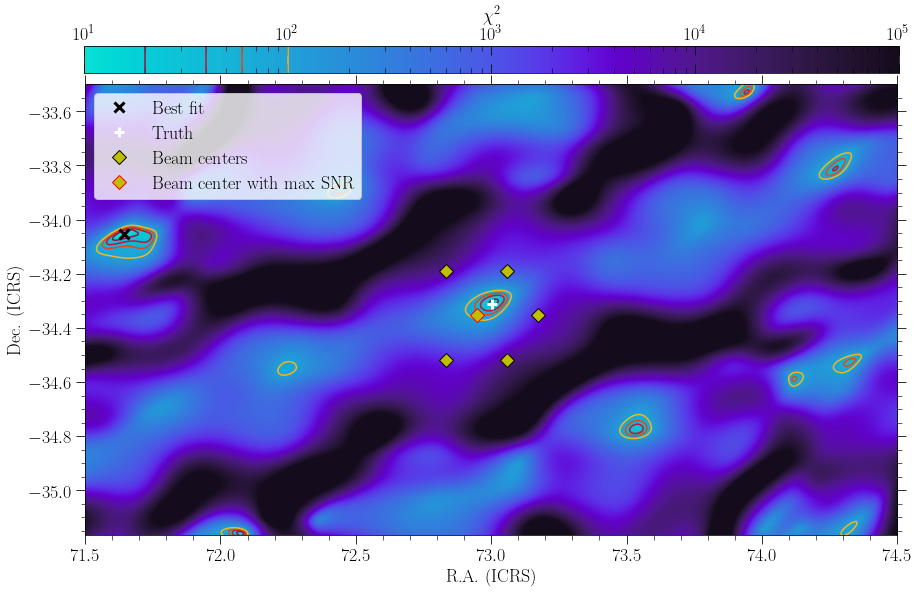

In [8]:
def chi2_plot(chi2, grid_ra, grid_dec, obs_beam_centers, obs_mask, contour_levels=[20,40,60,100], truth_coords=None):
    map_extent = [grid_ra.min(),
                  grid_ra.max(),
                  grid_dec.min(),
                  grid_dec.max()]

    aspect = 'equal'

    cmap = cms.get_sub_cmap(cms.cosmic_r,0.1,0.9)
    cmapnorm = colors.LogNorm(vmin=1e1, vmax=1e5, clip=False)
    contour_cmap = cms.get_sub_cmap(cms.ember,0.4,0.9)
    
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(1,1,1)

    # chi2 map
    ax1_img = ax1.imshow(chi2, aspect=aspect, extent=map_extent, cmap=cmap, norm=cmapnorm)
    # contours for specific levels of chi2
    ax1_ctr = ax1.contour(chi2, levels=contour_levels, extent=map_extent, origin='image', cmap=contour_cmap)

    # Coordinates associated with minimum chi2 
    best_ra_index, best_dec_index = np.unravel_index(np.argmin(chi2), chi2.shape)
    best_ra, best_dec = GRID_RA[best_ra_index, best_dec_index], GRID_DEC[best_ra_index, best_dec_index]
    ax1.plot(best_ra, best_dec,'xk', markersize=10,mew=3,label='Best fit')

    # Truth Coordinates for comparison
    if truth_coords:
        ax1.plot(truth_coords.ra.deg, truth_coords.dec.deg, '+w', markersize=10,mew=3,label='Truth')

    # Beams
    #ax1.plot(look_ra[OBS_MASK], look_dec[OBS_MASK], 'Dy',mec='k', ms=10, label='Look beam centers')
    #ax1.plot(look_ra[~OBS_MASK], look_dec[~OBS_MASK], 'Dy',mec='r', ms=10, label='Look beam center with max SNR')
    ax1.plot(OBS_BEAM_CENTERS.ra.deg[obs_mask], OBS_BEAM_CENTERS.dec.deg[obs_mask], 'Dy', mec='k', ms=10, label='Beam centers')
    ax1.plot(OBS_BEAM_CENTERS.ra.deg[~obs_mask], OBS_BEAM_CENTERS.dec.deg[~obs_mask], 'Dy', mec='r', ms=10, label='Beam center with max SNR')
    
    ax1.legend(fontsize=18, loc=2)
    ax1.set_xlabel('R.A. (ICRS)',fontsize=18,ha='center')
    ax1.set_ylabel('Dec. (ICRS)',fontsize=18,ha='center')
    ax1.minorticks_on()
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='major', length=9)
    ax1.tick_params(axis='both', which='minor', length=4.5)
    ax1.tick_params(axis='both', which='both', direction='out', right=True, top=True)

    cbar = fig.colorbar(ax1_img, ax=fig.axes, shrink=0.73, orientation='horizontal',location='top', aspect=30, pad=0.02)
    cbar.add_lines(ax1_ctr)
    cbar.ax.set_title(r'$\chi^2$',fontsize=18,ha='center')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(which='major',direction='in',length=9,bottom=True,top=True)
    cbar.ax.tick_params(which='minor',direction='in',length=5,bottom=True,top=True)
    cbar.ax.xaxis.set_tick_params(labelsize=18)
    return fig


TRUTH_COORDS=SkyCoord(73.0029167, -34.3116667, frame='icrs', unit=(u.deg,u.deg))
chi2_plot(CHI2, GRID_RA, GRID_DEC, OBS_BEAM_CENTERS, OBS_MASK, truth_coords=TRUTH_COORDS);